# Reading initial topo from map image 

Define a region 

```
(lon0, lon1, lat0, lat1)
```

and plot a map from etopo1 for that region. Then map the image data to mesh height ... 





In [3]:
%pylab inline

from badlands import meshtools 
from badlands import TreMesh
from badlands import HeightMesh
from badlands import SurfaceProcessMesh

import numpy as np


Populating the interactive namespace from numpy and matplotlib


In [4]:
import cartopy
import gdal, osr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


localetopo       = gdal.Open("Resources/etopo1_bedrock_90_105_20_35.tiff")
localetopo_img   = localetopo.ReadAsArray()
img_heights = localetopo_img.reshape(-1)
base_projection = ccrs.PlateCarree()
data_extent = (90, 105, 20, 35)

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                        edgecolor='Blue', facecolor="none")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

In [5]:
# This is how to dig into the natural earth features and find out what they are

# it = coastline.geometries()
# for i in it:
#     print i

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


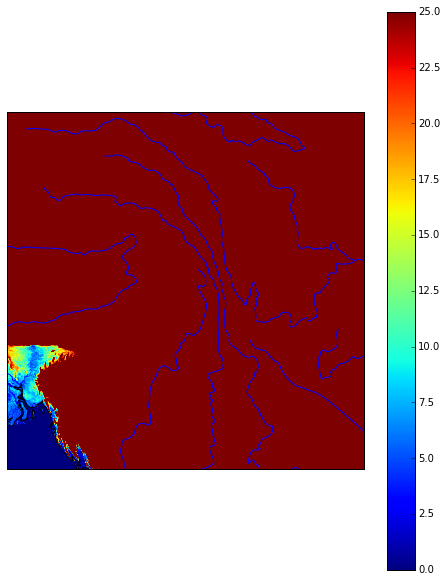

In [6]:
# Double check the coastline / height data are in sync 

fig = plt.figure(figsize=(8, 10), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(data_extent)

plt.imshow(localetopo_img, zorder=0, transform=base_projection, extent=data_extent, vmin=0.0, vmax=25.0)
plt.colorbar()

clf = ax.add_feature(coastline, linewidth=1, edgecolor="Black", zorder=1)
rvf = ax.add_feature(rivers, linewidth=1,    edgecolor="Blue", zorder=2)

plt.show()

In [7]:
x1, y1, bmask, inverse_bmask = meshtools.square_mesh(*data_extent, spacingX=0.1, spacingY=0.1, 
                                                     samples=100000, boundary_samples=200)
z1 = np.zeros_like(x1)

x5,y5 = meshtools.lloyd_mesh_improvment(x1,y1, bmask, 5)
z5 = np.zeros_like(x5)

# mesh1 = SurfaceProcessMesh(x1, y1, z1, None, None, None, bmask, verbose=True)
mesh5 = SurfaceProcessMesh(x5, y5, z5, None, None, None, bmask, verbose=True)

 - Calculating Delaunay Triangulation  1.110127 s
 - Triangulation Neighbour Lists  4.927027 s
 - Triangulation Local Areas and Weights  3.120218 s
 - Triangulation Vector Operators  3.403961 s
 - Local Smoothing Operator  0.582424 s
 - Sorted all nodes by height (high to low)  0.330732 s
 - Built downhill matrices  0.385163 s
 - Built cumulative area 0.001246 s
 - Found low points 0.283869 s
 - Found outflow points 0.311027 s


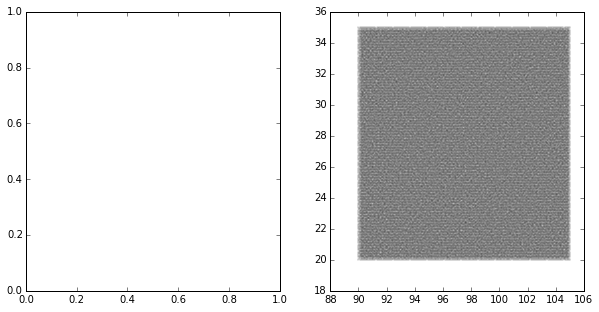

In [8]:
# Verify that this clunky algorithm didn't blow up any points near the edges:

fig, (plot1, plot2) = plt.subplots(1,2)
fig.set_size_inches(10,5)

#plot1.scatter(x1,y1,marker="o", s=0.01)
plot2.scatter(x5,y5,marker="o", s=0.01)

#fig.savefig("meshTest.png", dpi=600)

In [9]:
## dump the mesh to a file

mesh5.dump_to_file("HimalayaMesh100000.npz")

In [10]:
# mesh5 = SurfaceProcessMesh(filename="HimalayaMesh100000.npz")

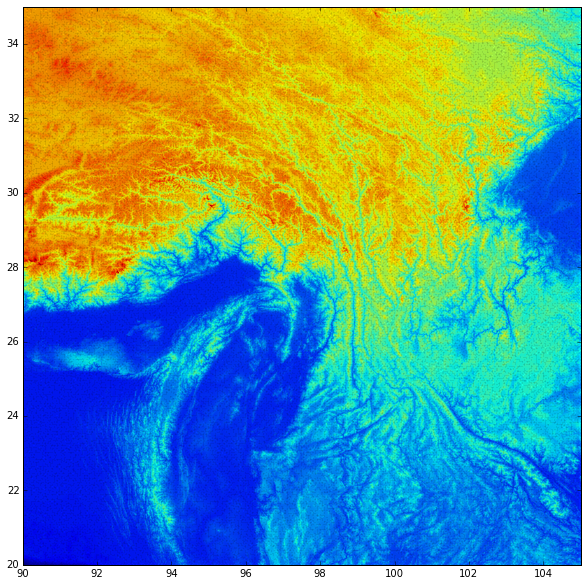

In [11]:
fig, (plot1) = plt.subplots(1)
fig.set_size_inches(10,10)

plot1.scatter(x5,y5,marker="o", s=0.01, zorder=1)
plt.imshow(localetopo_img,    zorder=0, extent=data_extent)

fig.savefig("meshHTest.png", dpi=600)


In [12]:
# lon / lat points for the image

datasize = localetopo_img.shape
lats = np.linspace(data_extent[3], data_extent[2], datasize[0])
lons = np.linspace(data_extent[0], data_extent[1], datasize[1])

lo, la = np.meshgrid(lons, lats)

lo = lo.reshape(-1)
la = la.reshape(-1)

lonlat = np.vstack((lo,la)).T


In [13]:
# Find triangle for each point (fast)
simplices = mesh5.tri.find_simplex(lonlat)

In [14]:
# tri_heights = np.zeros(mesh5.tri.nsimplex)
# img_heights = globaletopo_img.reshape(-1)

# for i, triangle in enumerate(simplices):
#     tri_heights[triangle] += img_heights[i]
    
# # Then map those back to the points ...     
    
# # mesh5.tri.simplices    
    
# z5 = np.zeros_like(x5)

# for t, height in enumerate(tri_heights):
#     z5[mesh5.tri.simplices[t]] += 0.33333 * height
    
    

In [15]:
# fig = plt.figure(figsize=(8, 10), facecolor="none")
# ax  = plt.axes(projection=ccrs.PlateCarree())
# fig.set_size_inches(10,10)
# fig.set_dpi(300)

# #plot1.set_xlim(0.0,1.0)
# #plot1.set_ylim(0.0,1.0)
# #mesh1.add_node_data_to_plot(plot1,phi, cmap=cm.terrain, shading="flat", vmin=-0.5, alpha=0.5)

# sm2a = mesh5.add_node_data_to_plot(ax, z5, cmap=cm.gist_earth, shading="gouraud", vmin=-1000, vmax=5000)

# ax.add_feature(coastline, linewidth=1.5,    edgecolor="Black", zorder=1)
# ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=2)
# ax.add_feature(rivers,    linewidth=4,    edgecolor="Blue", zorder=3, alpha=0.25)

# fig.savefig("meshHTest2.png", dpi=600)



In [16]:
## Function to compute barycentric coords for an array of points (efficiently)

def b_coords_array(mesh, coords):
        """
        Array version of b_coords
        """
        tcentres = np.zeros((mesh.tri.nsimplex, 2))
        tcentres = mesh.tri.transform[:,2,:]

        lcoords = np.zeros_like(lonlat)
        lcoords[:] = lonlat[:] - tcentres[simplices[:]]  

        tmatrix = np.zeros((mesh.tri.nsimplex, 2, 2))
        tmatrix = mesh.tri.transform[:,:2,:2]

        bary = np.zeros((len(lonlat),3))

        bary[:,0] = tmatrix[simplices[:],0,0] * lcoords[:,0] + tmatrix[simplices[:],0,1] * lcoords[:,1]
        bary[:,1] = tmatrix[simplices[:],1,0] * lcoords[:,0] + tmatrix[simplices[:],1,1] * lcoords[:,1]
        bary[:,2] = 1.0 - bary[:,0] - bary[:,1]
        
        return bary

# Map heights to mesh via barycentric coords

## 1 - Calculate the coords for each point in the image    

bary = b_coords_array(mesh5, lonlat)

## 2 Cache the trianges for each point in the image

tnodes = np.zeros((len(img_heights),3))
tnodes = mesh5.tri.simplices[simplices[:]]

## Now map heights to mesh nodes (and normalise)

z5 = np.zeros_like(x5)
norm5 = np.zeros_like(x5)

z5[tnodes[:,0]] += bary[:,0] * img_heights[:]
z5[tnodes[:,1]] += bary[:,1] * img_heights[:]
z5[tnodes[:,2]] += bary[:,2] * img_heights[:]

norm5[tnodes[:,0]] += bary[:,0] 
norm5[tnodes[:,1]] += bary[:,1] 
norm5[tnodes[:,2]] += bary[:,2] 

norm5[ norm5 == 0.0] = 1.0

z5 = z5 / norm5

mesh5.height[:] = z5[:]

In [17]:
## inject the new height data into the mesh and rebuild 

mesh5.verbose=True
mesh5.storeDense=True
mesh5.update_height(z5)
mesh5.update_surface_processes()
mesh5.slope[inverse_bmask] = 0.0



# Update surface processes will reset the stored matrices and rebuild them (if storedDense is True) 
# Subsequent calls would be faster

import time

walltime=time.clock()
mesh5.cumulative_flow(mesh5.area)
print " - Built cumulative area ", time.clock() - walltime,"s"


 - Sorted all nodes by height (high to low)  0.456719 s
 - Built downhill matrices  0.349157 s
 - Built cumulative area 0.091897 s
 - Found low points 0.056373 s
 - Found outflow points 0.053213 s
 - Built cumulative area  0.084309 s


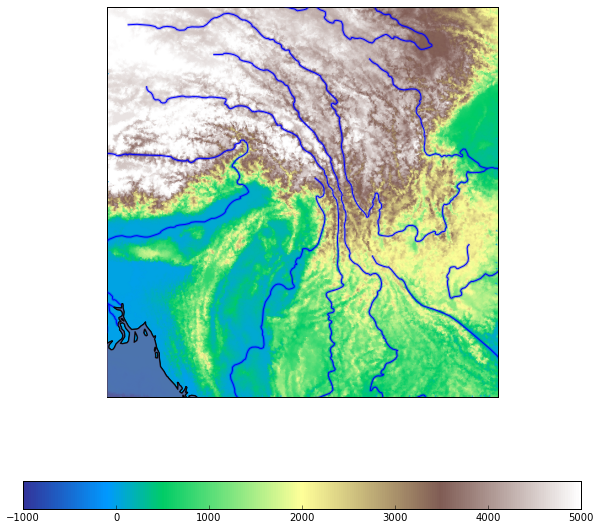

In [18]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())

heightplot = mesh5.add_node_data_to_plot(ax, z5, cmap=cm.terrain, shading="gouraud", vmin=-1000, vmax=5000)
fig.colorbar(heightplot, ax=ax, orientation='horizontal', ticks=[-1000, 0.0, 1000, 2000, 3000, 4000, 5000])

ax.add_feature(coastline, linewidth=1.5,    edgecolor="Black", zorder=1)
ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=2)
ax.add_feature(rivers,    linewidth=3,    edgecolor="Blue", zorder=3, alpha=0.25)
ax.add_feature(ocean, facecolor=(0.4,0.4,0.6), edgecolor=(0.0,0.0,0.0), linewidth=1, alpha=0.75, zorder=4)

fig.savefig("meshHTest3.png", dpi=600)


In [19]:
%%sh

open meshHtest3.png

In [21]:


if False:

    mesh5.build_node_chains()

    fig = plt.figure(figsize=(12, 12), facecolor="none")
    # plt.xlim(minX, maxX)
    # plt.ylim(minY, maxY)

    # plt.xlim(-5.1,5.1)
    # plt.ylim(-5.1,5.1)

    power = mesh5.slope * mesh5.upstream_area # each to some power, but this is a good start.

    log_upstream_area = np.log(mesh5.upstream_area)
    # downstream_dist   = mesh5.node_downstream_distance

    stream_color_var = power
    stream_width_var = log_upstream_area

    norm1 = plt.Normalize(vmin=stream_color_var.min(), vmax=stream_color_var.max())
    norm2 = plt.Normalize(vmin=stream_width_var.min(), vmax=stream_width_var.max())

    for idx, chain in enumerate(mesh5.node_chain_list[-1:0:-1]):
        xx = mesh5.tri.points[chain].T[0]
        yy = mesh5.tri.points[chain].T[1]

        for nn,node in enumerate(chain[0:-1]):
            xs = (xx[nn], xx[nn+1])
            ys = (yy[nn], yy[nn+1])

            color = plt.cm.YlOrRd_r( norm1(stream_color_var[node]) )
            width = 4.0 * norm2(stream_width_var[node])
            plt.plot(xs,ys, color=color, alpha=0.25, marker="", linewidth=width)



    # plt.triplot(x, y, tri.simplices.copy(), linewidth=0.5, color="#AABBBB", zorder=2)
    plt.tripcolor(mesh5.x, mesh5.y, mesh5.tri.simplices.copy(), mesh5.height, cmap=cm.terrain, shading="gouraud", vmin=-0.5, alpha=0.25)

    fig.savefig("DrainageChains", dpi=600)






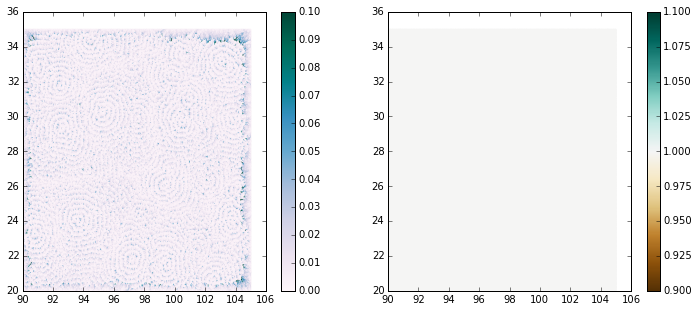

In [26]:
# We can map rainfall to outflow like this

rainfall_pattern = np.maximum(500.0,np.minimum(mesh5.height, 5000)) # say !
rainfall_pattern /= rainfall_pattern.max()
cumulative_rainfall = mesh5.cumulative_flow(mesh5.area * rainfall_pattern) 
stream_power = cumulative_rainfall * mesh5.slope


fig, (plot1, plot2) = plt.subplots(1,2)
fig.set_size_inches(12,5)

# plot1.set_xlim(-5.1, 5.1)
# plot1.set_ylim(-5.1, 5.1)
# plot2.set_xlim(-5.1, 5.1)
# plot2.set_ylim(-5.1, 5.1)

sm1a = mesh5.add_node_data_to_plot(plot1, mesh5.upstream_area, cmap=cm.PuBuGn, shading="gouraud", vmin=0.0, vmax=0.1)
# sm1b = mesh5.add_node_data_to_plot(plot1, rainfall_pattern, cmap=cm.BrBG, shading="gouraud", alpha=0.1)
# if len(mesh5.low_points):
#      plot1.scatter(mesh5.x[mesh5.low_points], mesh5.y[mesh5.low_points],2, marker="o", alpha=0.1)


fig.colorbar(sm1a, ax=plot1)

# Or this

rainflux = np.exp(-0.2*((mesh5.x-1.25)**2 + mesh5.y**2))**2
rainfall = mesh5.area * rainflux 
cumulative_rain = mesh5.cumulative_flow(rainfall)

# sm2a = mesh5.add_node_data_to_plot(plot2, stream_power / mesh5.area, cmap=cm.PuBuGn, shading="gouraud", vmax=(stream_power[bmask]/mesh5.area[bmask]).max()*0.5)
sm2b = mesh5.add_node_data_to_plot(plot2, rainfall_pattern, cmap=cm.BrBG, shading="gouraud", alpha=1.0)
fig.colorbar(sm2b, ax=plot2)

fig.savefig("eyeballs", dpi=600)

In [ ]:
%%sh

open eyeballs.png

In [23]:
if False:
    vector = np.ones(mesh5.tri.npoints)

    DX0 = vector.copy()
    DX1 = vector.copy()

    fig, (plot1) = plt.subplots(1,1)
    fig.set_size_inches(5,5)

    #plot1.axes.set_aspect("equal")

    # lim = 5.0
    # plot1.set_xlim(-lim, lim)
    # plot1.set_ylim(-lim, lim)

    step=0
    while DX1.any() and step < 150: 
        print step

        if step%5==0 or step < 10:
            plot1.triplot(mesh5.x, mesh5.y, mesh5.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
            sm1 = mesh5.add_node_data_to_plot(plot1, DX1, vmin=0.0, vmax=1.0, cmap=cm.YlOrRd, shading="gouraud", alpha=0.5, zorder=1)
            fig.savefig("InformationProp.{:03d}.png".format(step), dpi=300)

        step += 1

        DX1 = mesh5.downhillMat.dot(DX1)
        DX0 += DX1    

In [25]:
# %%prun -s cumulative -q -T prunErosionDeposition

# Test the time evolution with a mid-point method

import time as systime

kappa = 1.0e-3
critical_slope = 2.0      # Critical value - assume slides etc take over to limit slope
lowest_slope   = 1.0e-3   # The slope where we cut off the erosion / deposition algorithm
base = 0.0
totalSteps = 0

mesh5.verbose = False

typical_l = np.sqrt(mesh5.area)

# Reset the height (or not)

h5 = mesh5.height
reset = True

if reset:
    totalSteps = 0
    h5 = np.exp(-0.025*(x5**2 + y5**2)**2) + 0.001 * np.random.rand(len(x5))
    mesh5.rainfall_pattern = h5**2  # say !
    mesh5.rainfall_pattern[ mesh5.x > 0] *= ( 1.0 - mesh5.x[ mesh5.x > 0] * 0.2 )**3
    mesh5.update_height(h5)
    mesh5.update_surface_processes()
    


time = 0.0
viz_time= 0.0
vizzes = 0

running_average_uparea = mesh5.cumulative_flow(mesh5.area * mesh5.rainfall_pattern)

for step in range(0,250):
    totalSteps += 1
    walltime = systime.clock()
    
    delta = h5-mesh5.height
    efficiency = 0.01 # + np.where(delta < -0.00, 0.01, 0.0)
  
    # Erosion + deposition
    
    erosion_rate, deposition_rate, stream_power = \
         mesh5.stream_power_erosion_deposition_rate2(efficiency=efficiency, 
                                                    smooth_power=1, 
                                                    smooth_low_points=0, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=mesh5.downhill_smoothing,
                                                    centre_weight_u=0.666, centre_weight=0.75)

        
    # Smooth deposition in flat areas ... perhaps this could be replaced by multiple pathways in 
    # flat areas.
    
    erosion_deposition_rate = erosion_rate - deposition_rate
    erosion_timestep    = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(erosion_rate)+0.000001)).min()
    deposition_timestep = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(deposition_rate)+0.000001)).min()
         
    # Diffusion
        
    diffDz, diff_timestep =  mesh5.landscape_diffusion_critical_slope(kappa, critical_slope, True)
        
    ## Mid-point method. Update the height and use this to estimate the new rates of 
    ## Change. Note that we have to assume that the flow pattern doesn't change for this 
    ## to work. This means we can't call the methods which do a full update !
    
    timestep = min(erosion_timestep, deposition_timestep, diff_timestep)
    time = time + timestep
    viz_time = viz_time + timestep

    # Height predictor step (at half time)
    
    height0 = mesh5.height.copy()
    mesh5.height -= 0.5 * timestep * (erosion_deposition_rate - diffDz )
    mesh5.height = np.clip(mesh5.height, base, 1.0e9)   
    
    # Deal with internal drainages !
    mesh5.height = mesh5.handle_low_points(base, 5)  
    gradZx, gradZy = mesh5.delaunay_grad(mesh5.height)
    mesh5.slope = np.sqrt(gradZx**2+gradZy**2)   
    
    # Recalculate based on mid-point values
    
    erosion_rate, deposition_rate, stream_power = \
         mesh5.stream_power_erosion_deposition_rate2(efficiency=efficiency, 
                                                    smooth_power=1, 
                                                    smooth_low_points=0, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=mesh5.downhill_smoothing,
                                                    centre_weight_u=0.666, centre_weight=0.75)
        
        
    # Smooth deposition in flat areas ...
             
    erosion_deposition_rate = erosion_rate - deposition_rate
    erosion_timestep    = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(erosion_rate)+0.000001)).min()
    deposition_timestep = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(deposition_rate)+0.000001)).min()
   
    diffDz, diff_timestep =  mesh5.landscape_diffusion_critical_slope(kappa, critical_slope, True)
 
    timestep = min(erosion_timestep, deposition_timestep, diff_timestep)
    
    # Now take the full timestep

    height0 -= timestep * (erosion_deposition_rate - diffDz )
    mesh5.height = np.clip(height0, base, 1.0e9)  
    mesh5.height = mesh5.handle_low_points(base, 5)

    mesh5.update_height(mesh5.height)
    mesh5.update_surface_processes()
    
    running_average_uparea = 0.5 * running_average_uparea + 0.5 * mesh5.cumulative_flow(mesh5.area * mesh5.rainfall_pattern)


    
    if step%10 == 0:
        print "{:04d} - ".format(step), \
          " dt - {:.5f} ({:.5f}, {:.5f}, {:.5f})".format(timestep, diff_timestep, erosion_timestep, deposition_timestep), \
          " time - {:.4f}".format(time), \
          " Max slope - {:.3f}".format(mesh5.slope.max()), \
          " Step walltime - {:.3f}".format(systime.clock()-walltime)
            
        # print low_point_report
              
    # Store data
    
    if( viz_time > 0.025 or step==0):

        viz_time = 0.0
        vizzes = vizzes + 1

        delta = h5-mesh5.height
        smoothHeight = mesh5.local_area_smoothing(mesh5.height, its=2, centre_weight=0.75)
         
        mesh5.dump_to_file("Sombrero1.{:04d}".format(vizzes), delta=delta, 
                            uparea=running_average_uparea, erosion=erosion_deposition_rate)




0000 -   dt - 0.81028 (0.81028, 25.25309, 2.33934)  time - 0.8103  Max slope - 0.037  Step walltime - 4.611
0010 -   dt - 0.60217 (0.81021, 9.13346, 0.60217)  time - 7.3454  Max slope - 0.042  Step walltime - 3.371
0020 -   dt - 0.81022 (0.81022, 19.79453, 5.14930)  time - 15.4477  Max slope - 0.042  Step walltime - 2.893
0030 -   dt - 0.81022 (0.81022, 21.39306, 11.46637)  time - 23.5499  Max slope - 0.042  Step walltime - 3.418
0040 -   dt - 0.81021 (0.81021, 20.82128, 16.57941)  time - 31.6521  Max slope - 0.042  Step walltime - 3.523
0050 -   dt - 0.81022 (0.81022, 20.84506, 10.30344)  time - 39.7543  Max slope - 0.041  Step walltime - 3.572
0060 -   dt - 0.81023 (0.81023, 21.76302, 18.59469)  time - 47.8566  Max slope - 0.041  Step walltime - 3.904
0070 -   dt - 0.81024 (0.81024, 16.67415, 15.56745)  time - 55.9590  Max slope - 0.040  Step walltime - 3.684
0080 -   dt - 0.81025 (0.81025, 26.25475, 23.16338)  time - 64.0615  Max slope - 0.040  Step walltime - 4.440
0090 -   dt - 0.

KeyboardInterrupt: 